# Capstone project 2 machine learning in-depth analysis

## Contents:

### * Loop through each of the dates, train and test, and report accuracy for each of the logistic regression, K-nearest neighbors, and random forest classifiers, with default hyperparameters

### * Plot each of the resulting accuracy curves over time

### * Sanity-check the test set accuracy by reiterating the first pass, but this time implementing ten-fold cross validation on the training set and comparing the accuracies between the validation and test sets

### * Implement ensemble models: voting classifier (using all three untuned models), bagging (using the untuned random forest classifier), and AdaBoost (using the untuned random forest classifier)

### * Tune the key hyperparameters for each of the three models by calling GridSearchCV with ten-fold CV over the first 25 months of data

### * Loop through the remaining N - 25 months (from January 1997 to July 2015) using the now-tuned logistic regression, KNN, and random forest classifiers, and report the accuracies

### * Over the same N - 25 months, re-run the voting classifier, bagging, and AdaBoost classifiers and report the accuracies

### * Compare and graph the accuracies between the tuned and untuned models

#################################################################################################################
#################################################################################################################\

### This notebook has one dependency (post_EDA.csv) and does not output any files

#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
%matplotlib inline

Suppress warnings

In [2]:
warnings.filterwarnings('ignore')

Initialize random_state and test_size

In [3]:
RAND = 1
test_set_size = 0.25

Read in the data -- only one CSV file

In [4]:
model = pd.read_csv('post_EDA.csv', header=0)

In [5]:
model.head()

,EFFECTIVE DATE,COMPANY,CUSIP,SALES_PRICE,BV_PRICE,ROA,EPS_PRICE,PRICE_MOMENTUM,EPS_MOMENTUM,NEXT_MONTH_TR,SALES-PRICE DISCRETE,BV-PRICE DISCRETE,ROA DISCRETE,EPS-PRICE DISCRETE,PRICE MOM DISCRETE,EPS-MOMENTUM DISCRETE,NEXT MONTH TR DISCRETE
0,19941230,A.G. Edwards,281760108,71.035611,0.484281,7.124138,0.081667,-0.060000,0.050000,0.020833,4,3,5,4,3,5,0
1,19941230,AFLAC Inc.,001055102,191.641594,0.045786,1.819224,0.007188,-0.003956,0.000000,0.082031,5,1,4,1,5,3,1
2,19941230,AMRESCO Inc.,031909104,23.286519,3.566218,19.328806,0.666667,-0.188811,0.041667,-0.074074,2,5,5,5,1,5,0
3,19941230,Aetna Inc. (Old),008140105,380.604775,0.259135,0.507874,0.023979,-0.029810,-0.073770,0.065040,5,2,1,1,4,1,1
4,19941230,Alex Brown Inc,013902101,19.933761,0.573544,5.829485,0.093498,0.027149,-0.053333,0.149794,2,3,5,4,5,1,1


Include date as datetime object

In [6]:
model['DATE'] = pd.to_datetime(model['EFFECTIVE DATE'].astype(str), format='%Y-%m-%d')

Only keep date, discrete features, and discrete target

In [7]:
model = model[['DATE', 'EFFECTIVE DATE', 'SALES-PRICE DISCRETE', 'BV-PRICE DISCRETE', 'ROA DISCRETE', 'EPS-PRICE DISCRETE', \
              'PRICE MOM DISCRETE', 'EPS-MOMENTUM DISCRETE', 'NEXT MONTH TR DISCRETE']]

Change column names

In [8]:
colnames = ['DATE', 'DATE_yyyymmdd', 'SALES_PRICE', 'BV_PRICE', 'ROA', 'EPS_PRICE', 'PRICE_MOMENTUM', 'EPS_MOMENTUM', \
            'NEXT_MONTH_RETURN']

model.columns = colnames

In [9]:
model.head()

,DATE,DATE_yyyymmdd,SALES_PRICE,BV_PRICE,ROA,EPS_PRICE,PRICE_MOMENTUM,EPS_MOMENTUM,NEXT_MONTH_RETURN
0,1994-12-30,19941230,4,3,5,4,3,5,0
1,1994-12-30,19941230,5,1,4,1,5,3,1
2,1994-12-30,19941230,2,5,5,5,1,5,0
3,1994-12-30,19941230,5,2,1,1,4,1,1
4,1994-12-30,19941230,2,3,5,4,5,1,1


#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

### Gather all of the dates to loop over

In [10]:
dates = list(model['DATE'].drop_duplicates())

#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

### As a first pass, implement the logistic regression, KNN, and random forest classifiers across all dates

In [11]:
logreg_scores = []
KNN_scores = []
RFC_scores = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates = list(model['DATE'].drop_duplicates())

for i in dates:
    model_loop = model[model['DATE'] == i]
    X = model_loop.iloc[:, 2:8]
    y = model_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    logreg = LogisticRegression(random_state=RAND)
    logreg.fit(X_train, y_train)
    logreg_scores.append(logreg.score(X_test, y_test))

    KNN = KNeighborsClassifier()
    KNN.fit(X_train, y_train)
    KNN_scores.append(KNN.score(X_test, y_test))

    RFC = RandomForestClassifier(random_state=RAND)
    RFC.fit(X_train, y_train)
    RFC_scores.append(RFC.score(X_test, y_test))

### Average test accuracies for each model

In [13]:
pd.DataFrame({'Logistic Regression': np.mean(logreg_scores), \
              'K-Nearest Neighbors': np.mean(KNN_scores), \
              'Random Forest': np.mean(RFC_scores)}, index=['Mean'])

,Logistic Regression,K-Nearest Neighbors,Random Forest
Mean,0.585694,0.567888,0.56086


#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

### Plots of the accuracies over time

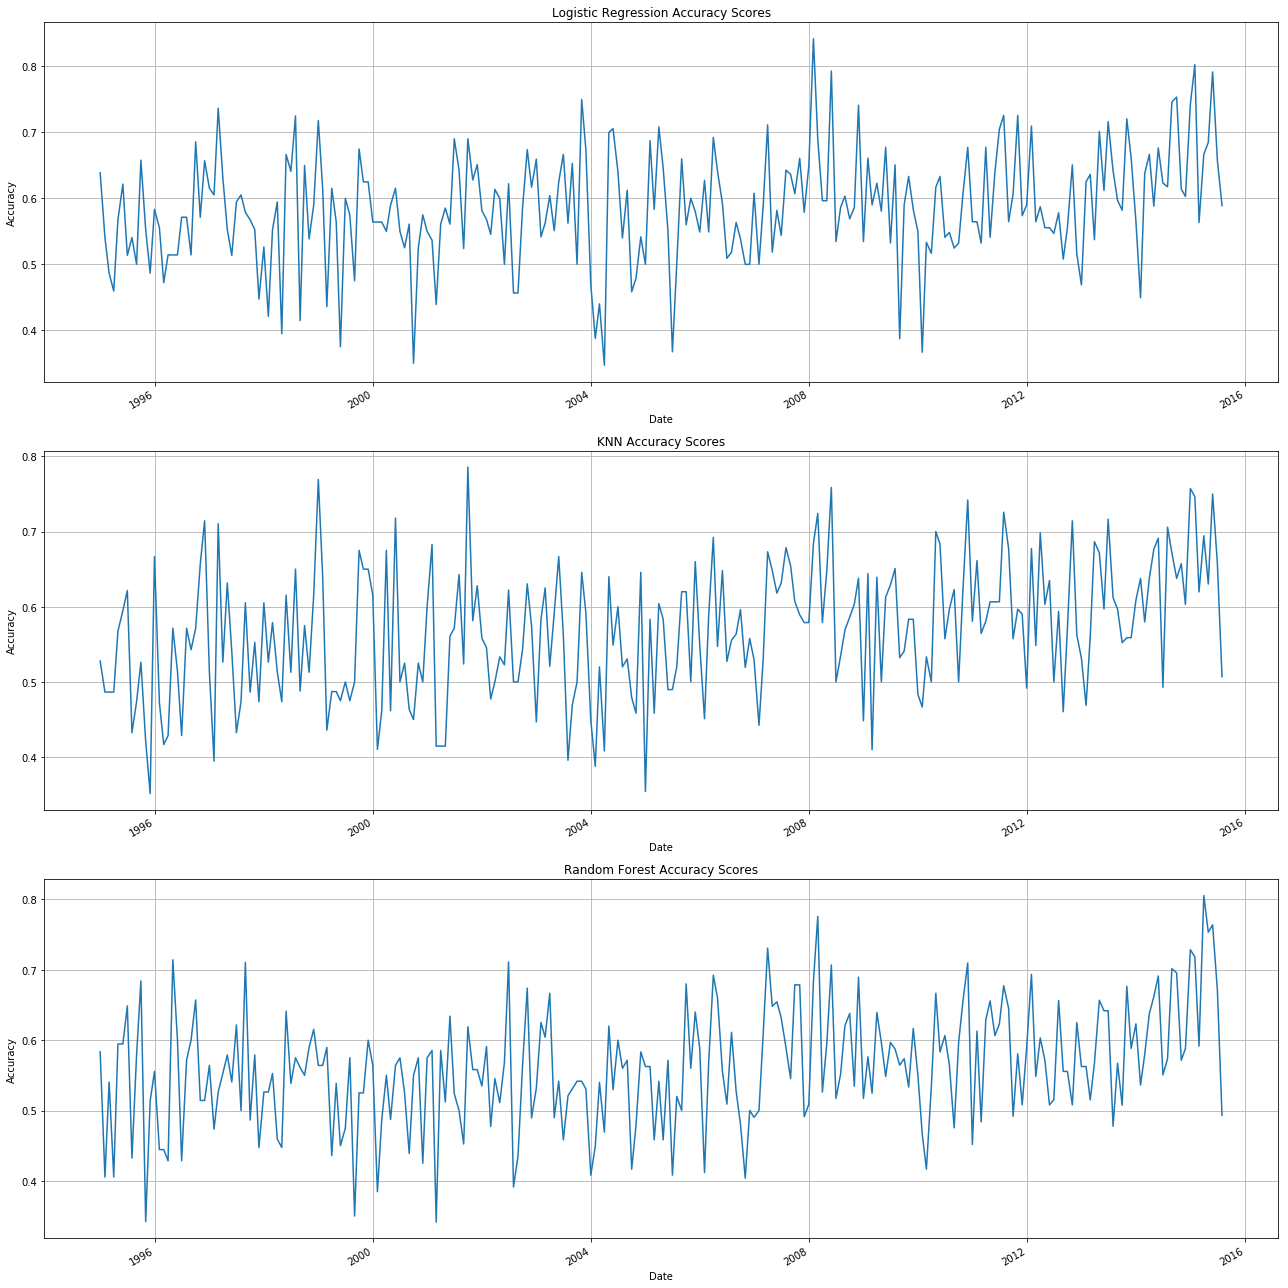

In [110]:
scores_1st_pass = pd.DataFrame({'Date': dates, 'Logistic Regression Scores': logreg_scores, \
                         'KNN Scores': KNN_scores, 'Random Forest Scores': RFC_scores, \
                         'Count': model.groupby('DATE')['DATE'].count()})

fig, axs = plt.subplots(3, 1, figsize=(18, 18), sharey=False)

ax = scores_1st_pass.plot(x='Date', y='Logistic Regression Scores', legend=False, ax=axs[0])
ax.set(title='Logistic Regression Accuracy Scores', xlabel='Date', ylabel='Accuracy')
ax.grid(which='both')

ax = scores_1st_pass.plot(x='Date', y='KNN Scores', legend=False, ax=axs[1])
ax.set(title='KNN Accuracy Scores', xlabel='Date', ylabel='Accuracy')
ax.grid(which='both')

ax = scores_1st_pass.plot(x='Date', y='Random Forest Scores', legend=False, ax=axs[2])
ax.set(title='Random Forest Accuracy Scores', xlabel='Date', ylabel='Accuracy')
ax.grid(which='both')

plt.tight_layout()
plt.show()

#################################################################################################################
#################################################################################################################

### As it appears that the accuracies are slightly increasing over time, plot the monthly stock count in order to see if the count is also increasing over time

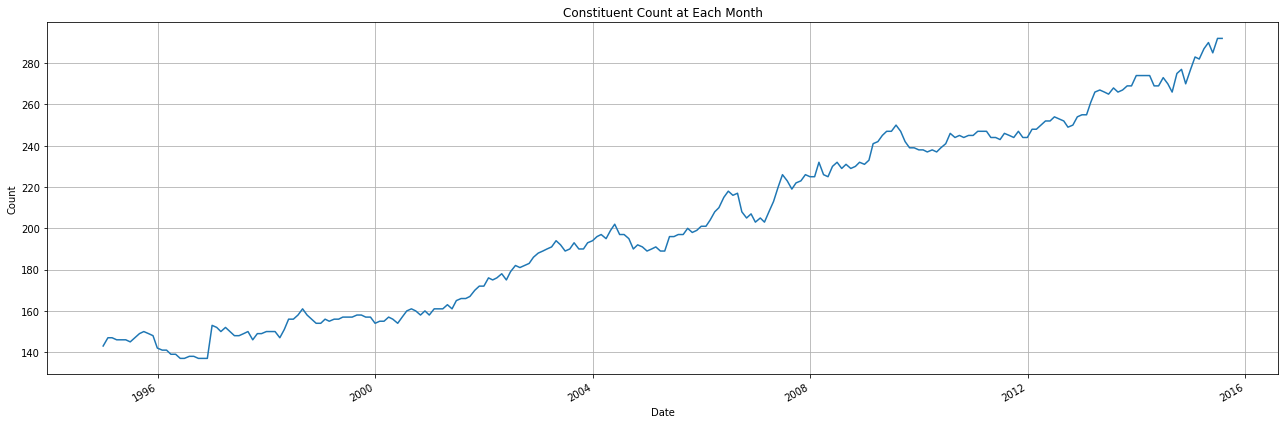

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(18, 6))

ax = scores_1st_pass['Count'].plot(legend=False)
ax.set(title='Constituent Count at Each Month', xlabel='Date', ylabel='Count')
ax.grid(which='both')

plt.tight_layout()
plt.show()

#################################################################################################################
#################################################################################################################

### Correlation matrix for each of the accuracies and the monthly stock count

In [16]:
scores_1st_pass.corr()

,Logistic Regression Scores,Random Forest Scores,KNN Scores,Count
Logistic Regression Scores,1.000000,0.497919,0.588321,0.269708
Random Forest Scores,0.497919,1.000000,0.592462,0.368852
KNN Scores,0.588321,0.592462,1.000000,0.366961
Count,0.269708,0.368852,0.366961,1.000000


#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

### Now explore accuracies for the training and test sets, and also those obtained by cross-validating the training set

### Logistic Regression

In [17]:
CV_logreg_scores = []
logreg_scores_train = []
logreg_scores_test = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates = list(model['DATE'].drop_duplicates())

for i in dates:
    model_loop = model[model['DATE'] == i]
    X = model_loop.iloc[:, 2:8]
    y = model_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    logreg = LogisticRegression(random_state=RAND)
    accuracy_loop_CV = cross_val_score(logreg, X_train, y_train, cv=10, n_jobs=-1)
    CV_logreg_scores.append(accuracy_loop_CV.mean())

    logreg.fit(X_train, y_train)
    logreg_scores_train.append(logreg.score(X_train, y_train))
    logreg_scores_test.append(logreg.score(X_test, y_test))

### Average accuracies for logistic regression training, validation, and test sets

In [18]:
pd.DataFrame({'Logistic Regression': [np.mean(logreg_scores_train), np.mean(CV_logreg_scores), \
                                      np.mean(logreg_scores_test)]}, index=['Training Set', 'Cross Validation', 'Test Set'])

,Logistic Regression
Training Set,0.633269
Cross Validation,0.583295
Test Set,0.585694


#################################################################################################################
#################################################################################################################

### K-Nearest Neighbors

In [19]:
CV_KNN_scores = []
KNN_scores_train = []
KNN_scores_test = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates = list(model['DATE'].drop_duplicates())

for i in dates:
    model_loop = model[model['DATE'] == i]
    X = model_loop.iloc[:, 2:8]
    y = model_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    KNN = KNeighborsClassifier()
    accuracy_loop_CV = cross_val_score(KNN, X_train, y_train, cv=10, n_jobs=-1)
    CV_KNN_scores.append(accuracy_loop_CV.mean())

    KNN.fit(X_train, y_train)
    KNN_scores_train.append(KNN.score(X_train, y_train))
    KNN_scores_test.append(KNN.score(X_test, y_test))

### Average accuracies for KNN training, validation, and test sets

In [20]:
pd.DataFrame({'K-Nearest Neighbors': [np.mean(KNN_scores_train), np.mean(CV_KNN_scores), np.mean(KNN_scores_test)]}, \
             index=['Training Set', 'Cross Validation', 'Test Set'])

,K-Nearest Neighbors
Training Set,0.723189
Cross Validation,0.571400
Test Set,0.567888


#################################################################################################################
#################################################################################################################

### Random Forest

In [21]:
CV_RFC_scores = []
RFC_scores_train = []
RFC_scores_test = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates = list(model['DATE'].drop_duplicates())

for i in dates:
    model_loop = model[model['DATE'] == i]
    X = model_loop.iloc[:, 2:8]
    y = model_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    RFC = RandomForestClassifier(random_state=RAND)
    accuracy_loop_CV = cross_val_score(RFC, X_train, y_train, cv=10, n_jobs=-1)
    CV_RFC_scores.append(accuracy_loop_CV.mean())

    RFC.fit(X_train, y_train)
    RFC_scores_train.append(RFC.score(X_train, y_train))
    RFC_scores_test.append(RFC.score(X_test, y_test))

### Average accuracies for training, validation, and test sets

In [22]:
pd.DataFrame({'Random Forest': [np.mean(RFC_scores_train), np.mean(CV_RFC_scores), np.mean(RFC_scores_test)]}, \
             index=['Training Set', 'Cross Validation', 'Test Set'])

,Random Forest
Training Set,0.970100
Cross Validation,0.570137
Test Set,0.560860


#################################################################################################################
#################################################################################################################

### Voting classifier using all three models

In [23]:
vc_scores = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates = list(model['DATE'].drop_duplicates())

for i in dates:
    model_loop = model[model['DATE'] == i]
    X = model_loop.iloc[:, 2:8]
    y = model_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    log_reg_VC = LogisticRegression(random_state=RAND)
    KNN_VC = KNeighborsClassifier()
    RFC_VC = RandomForestClassifier(random_state=RAND)

    classifiers = [('Logistic Regression', log_reg_VC), ('K Nearest Neighbors', KNN_VC), ('Random Forest', RFC_VC)]

    vc = VotingClassifier(estimators=classifiers)
    vc.fit(X_train, y_train)
    vc_scores.append(vc.score(X_test, y_test))

### Mean and variance of accuracies for the voting classifier

In [24]:
pd.DataFrame({'Voting Classifier': [np.mean(vc_scores), np.var(vc_scores)]}, index=['Mean', 'Variance'])

,Voting Classifier
Mean,0.581397
Variance,0.007409


#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

### Bagging classifier using the random forest classifier

#### At the bagging classifier level, use 50 estimators and test on the out-of-bag observations

In [25]:
test_accuracies = []
oob_accuracies = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates = list(model['DATE'].drop_duplicates())

for i in dates:
    model_loop = model[model['DATE'] == i]
    X = model_loop.iloc[:, 2:8]
    y = model_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    RFC = RandomForestClassifier(random_state=RAND)
    bc = BaggingClassifier(base_estimator=RFC, n_estimators=50, oob_score=True, n_jobs=-1)
    bc.fit(X_train, y_train)
    y_pred = bc.predict(X_test)
    test_accuracies.append(accuracy_score(y_test, y_pred))
    oob_accuracies.append(bc.oob_score_)

### Mean and variance of accuracies for the bagging classifier -- (1) via test set, and (2) via out-of-bag set

In [26]:
pd.DataFrame({'Test Set': [np.mean(test_accuracies), np.var(test_accuracies)], \
            'Out-of-Bag Set': [np.mean(oob_accuracies), np.var(oob_accuracies)]}, \
            index=['Mean', 'Variance'])

,Test Set,Out-of-Bag Set
Mean,0.581474,0.584055
Variance,0.007301,0.005248


#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

### AdaBoost classifier using the random forest classifier

#### At the AdaBoost classifier level, use 50 estimators and test on the out-of-bag observations

In [27]:
adb_scores = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates = list(model['DATE'].drop_duplicates())

for i in dates:
    model_loop = model[model['DATE'] == i]
    X = model_loop.iloc[:, 2:8]
    y = model_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    RFC = RandomForestClassifier(random_state=RAND)
    adb_clf = AdaBoostClassifier(base_estimator=RFC, n_estimators=50, learning_rate=0.5)
    adb_clf.fit(X_train, y_train)
    adb_scores.append(adb_clf.score(X_test, y_test))

### Mean and variance of accuracies for the AdaBoost classifier

In [28]:
pd.DataFrame({'AdaBoost': [np.mean(adb_scores), np.var(adb_scores)]}, index=['Mean', 'Variance'])

,AdaBoost
Mean,0.560794
Variance,0.006523


#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

# Hyperparameter-tune the logistic regression, KNN, and random forest models

## Tune over the monthly selections from December 1994 to December 1996

### Re-implement the procedures from earlier, but this time using the "best" hyperparameters obtained via GridSearchCV:

#### * Run the three models individually from January 1997 to the end (July 2015) and compute accuracy scores

#### * Integrate all three models into a voting classifier, run from Jan. 1997 to Jul. 2015, and compute accuracy scores

#### * Run the bagging classifier using the tuned random forest as the base estimator from 1997 to 2015 and compute accuracy scores

#### * Run the AdaBoost classifier using the tuned random forest as the base estimator from 1997 to 2015 and compute accuracy scores

#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

### Subset the dataframe by dates before and including December 1996

In [29]:
model_short = model[model['DATE'] <= '1996-12-31']

In [30]:
X_mod_sh = model_short.iloc[:, 2:8]
y_mod_sh = model_short.iloc[:, -1]

### Subset the dataframe by dates after December 1996

In [31]:
model_long = model[model['DATE'] > '1996-12-31']

In [32]:
X_mod_lg = model_long.iloc[:, 2:8]
y_mod_lg = model_long.iloc[:, -1]

#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

### Gather all of the dates to loop over

In [33]:
dates_long = list(model_long['DATE'].drop_duplicates())

#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

### GridSearchCV on the logistic regressor using ten-fold CV on the training data (i.e., Dec. 1994 to Dec. 1996)

In [38]:
logreg_short = LogisticRegression(random_state=RAND)
logreg_params = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

logreg_gscv = GridSearchCV(logreg_short, param_grid=logreg_params, cv=10)
logreg_gscv.fit(X_mod_sh, y_mod_sh)

print('Best hyperparameters using GridSearchCV:', logreg_gscv.best_params_)
print('Best GridSearchCV score:', logreg_gscv.best_score_)

Best hyperparameters using GridSearchCV: {'C': 0.01}
Best GridSearchCV score: 0.5386979603241129


### Implement the tuned logsitic regressor over all months after December 1996 and compute mean accuracy and variance thereof

In [39]:
logreg_long_scores = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates_long = list(model_long['DATE'].drop_duplicates())

for i in dates_long:
    model_lg_loop = model_long[model_long['DATE'] == i]
    X = model_lg_loop.iloc[:, 2:8]
    y = model_lg_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    logreg_long = LogisticRegression(C=0.01, random_state=RAND)
    logreg_long.fit(X_train, y_train)
    logreg_long_scores.append(logreg_long.score(X_test, y_test))

#################################################################################################################
#################################################################################################################

### GridSearchCV on the KNN classifier using ten-fold CV on the training data

In [36]:
KNN_short = KNeighborsClassifier()
KNN_params = {'n_neighbors': list(range(1, 41))}

KNN_gscv = GridSearchCV(KNN_short, param_grid=KNN_params, cv=10)
KNN_gscv.fit(X_mod_sh, y_mod_sh)

print('Best hyperparameters using GridSearchCV:', KNN_gscv.best_params_)
print('Best GridSearchCV score:', KNN_gscv.best_score_)

Best hyperparameters using GridSearchCV: {'n_neighbors': 34}
Best GridSearchCV score: 0.5152277172394524


### Implement the tuned KNN classifier over all months after December 1996 and compute mean accuracy and variance thereof

In [37]:
KNN_long_scores = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates_long = list(model_long['DATE'].drop_duplicates())

for i in dates_long:
    model_lg_loop = model_long[model_long['DATE'] == i]
    X = model_lg_loop.iloc[:, 2:8]
    y = model_lg_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    KNN_long = KNeighborsClassifier(n_neighbors=34)
    KNN_long.fit(X_train, y_train)
    KNN_long_scores.append(KNN_long.score(X_test, y_test))

#################################################################################################################
#################################################################################################################

### GridSearchCV on the random forest classifier using ten-fold CV on the training data

In [34]:
# recall that RAND = 1

RFC_short = RandomForestClassifier(random_state=RAND)
RFC_params = {'n_estimators': [100, 150, 200, 250, 300], 'max_features': [2, 3, 4], 'max_depth': [2, 3, 4]}

RFC_gscv = GridSearchCV(RFC_short, param_grid=RFC_params, cv=10)
RFC_gscv.fit(X_mod_sh, y_mod_sh)

print('Best hyperparameters using GridSearchCV:', RFC_gscv.best_params_)
print('Best GridSearchCV score:', RFC_gscv.best_score_)

Best hyperparameters using GridSearchCV: {'max_depth': 4, 'max_features': 3, 'n_estimators': 250}
Best GridSearchCV score: 0.5384185526683432


### Implement the tuned random forest over all months after December 1996 and compute mean accuracy and variance thereof

In [35]:
RFC_long_scores = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates_long = list(model_long['DATE'].drop_duplicates())

for i in dates_long:
    model_lg_loop = model_long[model_long['DATE'] == i]
    X = model_lg_loop.iloc[:, 2:8]
    y = model_lg_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    RFC_long = RandomForestClassifier(n_estimators=250, max_depth=4, max_features=3, random_state=RAND)
    RFC_long.fit(X_train, y_train)
    RFC_long_scores.append(RFC_long.score(X_test, y_test))

#################################################################################################################
#################################################################################################################

### Mean and variance of accuracies across the tuned logistic regression, KNN, and random forest models

In [40]:
pd.DataFrame({'Logistic Regression': [np.mean(logreg_long_scores), np.var(logreg_long_scores)], \
             'K-Nearest Neighbors': [np.mean(KNN_long_scores), np.var(KNN_long_scores)], \
             'Random Forest': [np.mean(RFC_long_scores), np.var(RFC_long_scores)]}, \
            index=['Mean', 'Variance'])

,Logistic Regression,K-Nearest Neighbors,Random Forest
Mean,0.580683,0.587559,0.588191
Variance,0.007403,0.006330,0.007584


#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

### Voting classifier using all three tuned models

In [41]:
vc_scores_long = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates_long = list(model_long['DATE'].drop_duplicates())

for i in dates_long:
    model_lg_loop = model_long[model_long['DATE'] == i]
    X = model_lg_loop.iloc[:, 2:8]
    y = model_lg_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    log_reg_VC = LogisticRegression(C=0.01, random_state=RAND)
    KNN_VC = KNeighborsClassifier(n_neighbors=34)
    RFC_VC = RandomForestClassifier(n_estimators=250, max_depth=4, max_features=3, random_state=RAND)

    classifiers = [('Logistic Regression', log_reg_VC), ('K Nearest Neighbors', KNN_VC), ('Random Forest', RFC_VC)]

    vc = VotingClassifier(estimators=classifiers)
    vc.fit(X_train, y_train)
    vc_scores_long.append(vc.score(X_test, y_test))

### Mean and variance of accuracies for the voting classifier

In [42]:
pd.DataFrame({'Voting Classifier': [np.mean(vc_scores_long), np.var(vc_scores_long)]}, index=['Mean', 'Variance'])

,Voting Classifier
Mean,0.593566
Variance,0.007662


#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

### Bagging classifier using the tuned random forest classifier

#### At the bagging classifier level, use 50 estimators and test on the out-of-bag observations

#### At the random forest classifier level, to economize runtime, depart from the tuned number of estimators (250) and instead use 10

In [43]:
test_accuracies_long = []
oob_accuracies_long = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates_long = list(model_long['DATE'].drop_duplicates())

for i in dates_long:
    model_lg_loop = model_long[model_long['DATE'] == i]
    X = model_lg_loop.iloc[:, 2:8]
    y = model_lg_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    RFC = RandomForestClassifier(n_estimators=10, max_depth=4, max_features=3, random_state=RAND)
    bc = BaggingClassifier(base_estimator=RFC, n_estimators=50, oob_score=True, n_jobs=-1)
    bc.fit(X_train, y_train)
    y_pred = bc.predict(X_test)
    test_accuracies_long.append(accuracy_score(y_test, y_pred))
    oob_accuracies_long.append(bc.oob_score_)

### Mean and variance of accuracies for the bagging classifier -- (1) via test set, and (2) via out-of-bag set

In [44]:
pd.DataFrame({'Test Set': [np.mean(test_accuracies_long), np.var(test_accuracies_long)], \
            'Out-of-Bag Set': [np.mean(oob_accuracies_long), np.var(oob_accuracies_long)]}, \
            index=['Mean', 'Variance'])

,Test Set,Out-of-Bag Set
Mean,0.591460,0.591346
Variance,0.007989,0.005463


#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

### AdaBoost classifier using the tuned random forest classifier

#### At the AdaBoost classifier level, use 50 estimators and test on the out-of-bag observations

#### At the random forest classifier level, to economize runtime, depart from the tuned number of estimators (250) and instead use 10

In [45]:
adb_scores_long = []

# recall that RAND = 1
# recall that test_set_size = 0.25
# recall that dates_long = list(model_long['DATE'].drop_duplicates())

for i in dates_long:
    model_lg_loop = model_long[model_long['DATE'] == i]
    X = model_lg_loop.iloc[:, 2:8]
    y = model_lg_loop.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=RAND)

    RFC = RandomForestClassifier(n_estimators=10, max_depth=4, max_features=3, random_state=RAND)
    adb_clf = AdaBoostClassifier(base_estimator=RFC, n_estimators=50, learning_rate=0.5)
    adb_clf.fit(X_train, y_train)
    adb_scores_long.append(adb_clf.score(X_test, y_test))

### Mean and variance of accuracies for the AdaBoost classifier

In [46]:
pd.DataFrame({'AdaBoost': [np.mean(adb_scores_long), np.var(adb_scores_long)]}, index=['Mean', 'Variance'])

,AdaBoost
Mean,0.563571
Variance,0.007636


#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

# Comparison of test set accuracies between the untuned and tuned models

## Note that the ensemble models are "tuned" insofar as the hyperparameters of the base models (logistic regressor, KNN, and random forest) were tuned

### Mean and variance of accuracies between the untuned and tuned logistic regression, KNN, and random forest classifiers

In [58]:
all_model_scores = pd.DataFrame({'Logistic Regression, untuned': [np.mean(logreg_scores[25:]), np.var(logreg_scores[25:])], \
              'Logistic Regression, tuned': [np.mean(logreg_long_scores), np.var(logreg_long_scores)], \
              'K-Nearest Neighbors, untuned': [np.mean(KNN_scores[25:]), np.var(KNN_scores[25:])], \
              'K-Nearest Neighbors, tuned': [np.mean(KNN_long_scores), np.var(KNN_long_scores)], \
              'Random Forest, untuned': [np.mean(RFC_scores[25:]), np.var(RFC_scores[25:])], \
              'Random Forest, tuned': [np.mean(RFC_long_scores), np.var(RFC_long_scores)]}, index=['Mean', 'Variance'])

all_model_scores

,"Logistic Regression, untuned","Logistic Regression, tuned","K-Nearest Neighbors, untuned","K-Nearest Neighbors, tuned","Random Forest, untuned","Random Forest, tuned"
Mean,0.588994,0.580683,0.573058,0.587559,0.563823,0.588191
Variance,0.007337,0.007403,0.007296,0.006330,0.006571,0.007584


### Mean and variance of accuracies between the untuned and tuned ensemble models

In [59]:
all_ensemble_scores = pd.DataFrame({'Voting Classifier, untuned': [np.mean(vc_scores[25:]), np.var(vc_scores[25:])], \
            'Voting Classifier, tuned': [np.mean(vc_scores_long), np.var(vc_scores_long)], \
            'Bagging Test Set, untuned': [np.mean(test_accuracies[25:]), np.var(test_accuracies[25:])], \
            'Bagging Test Set, tuned': [np.mean(test_accuracies_long), np.var(test_accuracies_long)], \
            'Bagging Out-of-Bag Set, untuned': [np.mean(oob_accuracies[25:]), np.var(oob_accuracies[25:])], \
            'Bagging Out-of-Bag Set, tuned': [np.mean(oob_accuracies_long), np.var(oob_accuracies_long)], \
            'AdaBoost, untuned': [np.mean(adb_scores[25:]), np.var(adb_scores[25:])], \
            'AdaBoost, tuned': [np.mean(adb_scores_long), np.var(adb_scores_long)]}, index=['Mean', 'Variance'])

all_ensemble_scores

,"Voting Classifier, untuned","Voting Classifier, tuned","Bagging Test Set, untuned","Bagging Test Set, tuned","Bagging Out-of-Bag Set, untuned","Bagging Out-of-Bag Set, tuned","AdaBoost, untuned","AdaBoost, tuned"
Mean,0.585123,0.593566,0.583120,0.591460,0.587039,0.591346,0.562028,0.563571
Variance,0.007205,0.007662,0.007537,0.007989,0.005350,0.005463,0.006480,0.007636


#################################################################################################################
#################################################################################################################

### Graphs of accuracies between the untuned and tuned models for each of the three classifiers

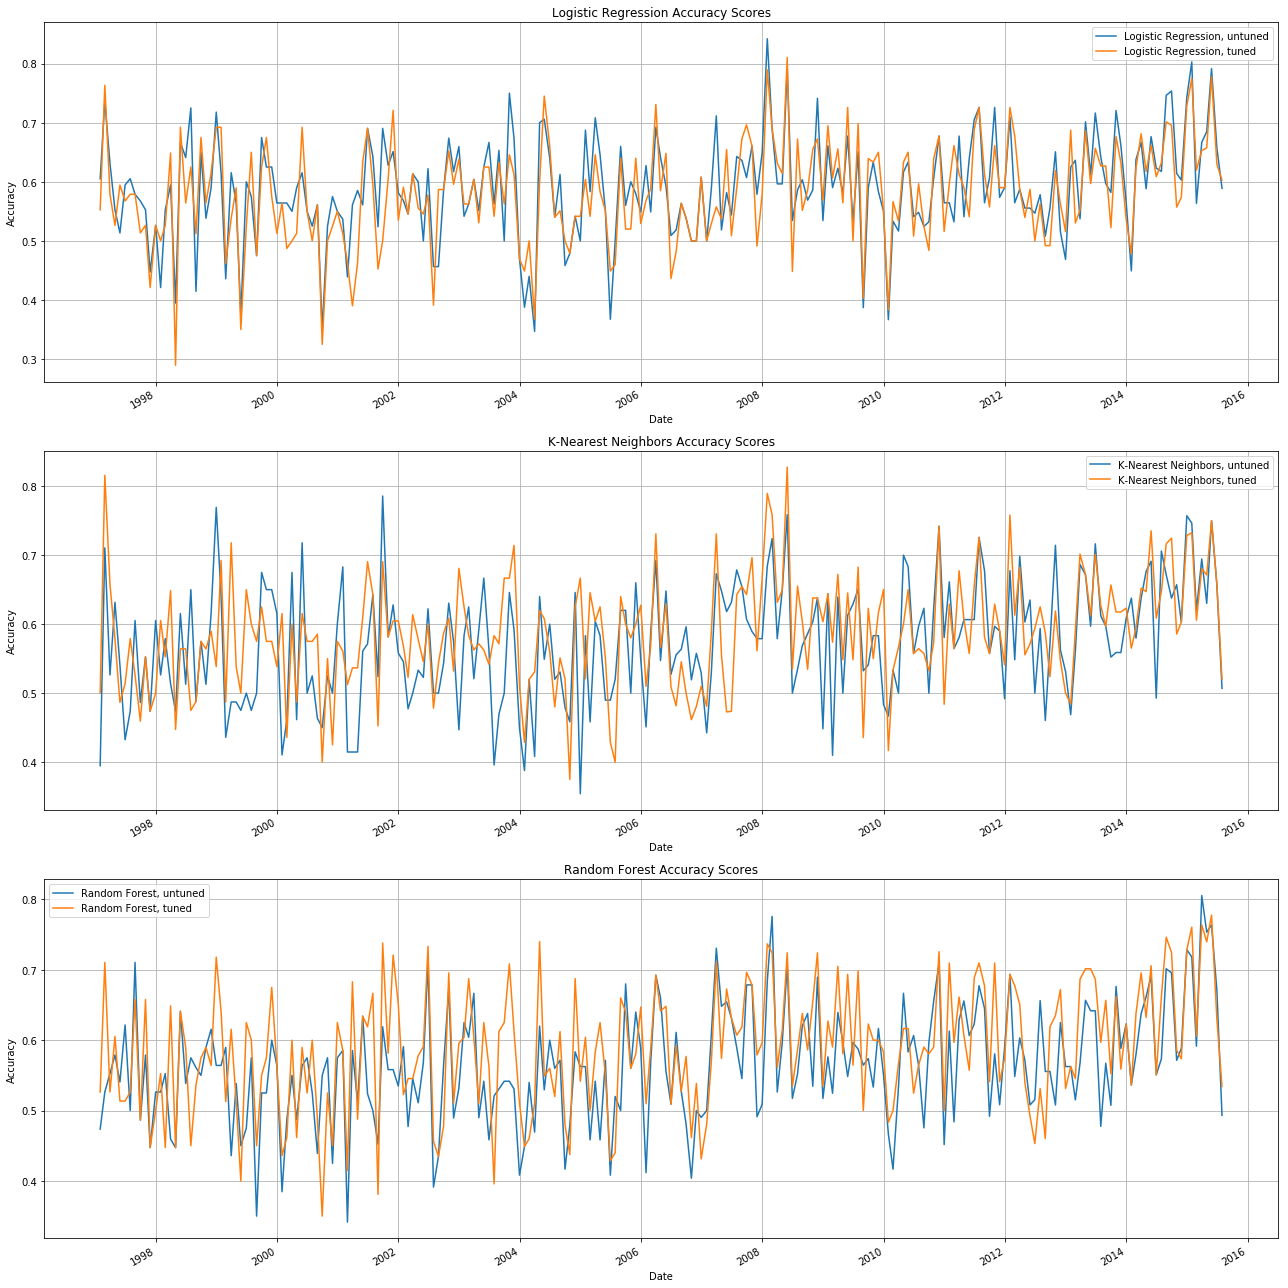

In [107]:
all_scores = pd.DataFrame({'Date': dates_long, 'Logistic Regression, untuned': logreg_scores[25:], \
                          'Logistic Regression, tuned': logreg_long_scores, 'K-Nearest Neighbors, untuned': KNN_scores[25:], \
                          'K-Nearest Neighbors, tuned': KNN_long_scores, 'Random Forest, untuned': RFC_scores[25:], \
                          'Random Forest, tuned': RFC_long_scores, 'Voting Classifier, untuned': vc_scores[25:], \
                          'Voting Classifier, tuned': vc_scores_long, 'Bagging Test Set, untuned': test_accuracies[25:], \
                          'Bagging Test Set, tuned': test_accuracies_long, \
                          'Bagging Out-of-Bag Set, untuned': oob_accuracies[25:], \
                          'Bagging Out-of-Bag Set, tuned': oob_accuracies_long, 'AdaBoost, untuned': adb_scores[25:], \
                          'AdaBoost, tuned': adb_scores_long})

all_scores.set_index('Date', inplace=True)

fig, axs = plt.subplots(3, 1, figsize=(18, 18), sharey=False)

ax = all_scores[['Logistic Regression, untuned', 'Logistic Regression, tuned']].plot(ax=axs[0])
ax.set(title='Logistic Regression Accuracy Scores', xlabel='Date', ylabel='Accuracy')
ax.grid(which='both')
ax.legend(loc='best')

ax = all_scores[['K-Nearest Neighbors, untuned', 'K-Nearest Neighbors, tuned']].plot(ax=axs[1])
ax.set(title='K-Nearest Neighbors Accuracy Scores', xlabel='Date', ylabel='Accuracy')
ax.grid(which='both')
ax.legend(loc='best')

ax = all_scores[['Random Forest, untuned', 'Random Forest, tuned']].plot(ax=axs[2])
ax.set(title='Random Forest Accuracy Scores', xlabel='Date', ylabel='Accuracy')
ax.grid(which='both')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

### Graphs of accuracies between the untuned and tuned models for each of the three ensemble models

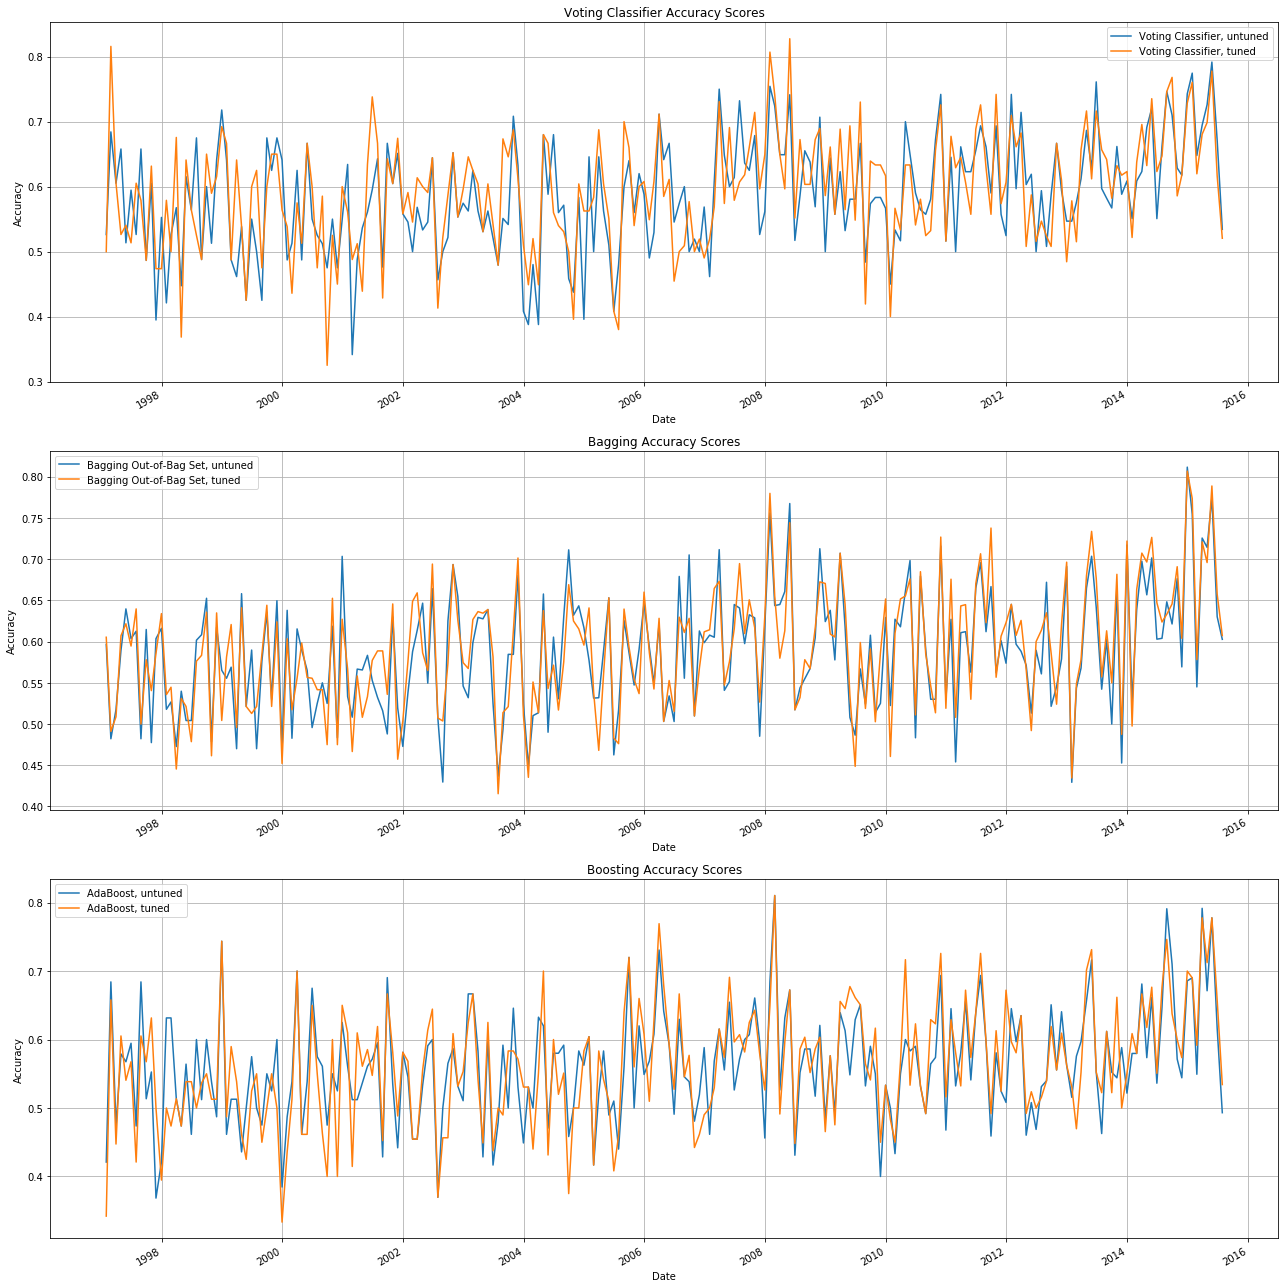

In [109]:
fig, axs = plt.subplots(3, 1, figsize=(18, 18), sharey=False)

ax = all_scores[['Voting Classifier, untuned', 'Voting Classifier, tuned']].plot(ax=axs[0])
ax.set(title='Voting Classifier Accuracy Scores', xlabel='Date', ylabel='Accuracy')
ax.grid(which='both')
ax.legend(loc='best')

ax = all_scores[['Bagging Out-of-Bag Set, untuned', 'Bagging Out-of-Bag Set, tuned']].plot(ax=axs[1])
ax.set(title='Bagging (OOB) Accuracy Scores', xlabel='Date', ylabel='Accuracy')
ax.grid(which='both')
ax.legend(loc='best')

ax = all_scores[['AdaBoost, untuned', 'AdaBoost, tuned']].plot(ax=axs[2])
ax.set(title='Boosting Accuracy Scores', xlabel='Date', ylabel='Accuracy')
ax.grid(which='both')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

#################################################################################################################
#################################################################################################################

### Check correlations between accuracy and stock count at each month

In [111]:
all_scores['Count'] = model_long.groupby('DATE')['DATE'].count()

In [119]:
pd.DataFrame(all_scores.corr().iloc[:-1, -1])

,Count
"Logistic Regression, untuned",0.252424
"Logistic Regression, tuned",0.300162
"K-Nearest Neighbors, untuned",0.349610
"K-Nearest Neighbors, tuned",0.318518
"Random Forest, untuned",0.389971
"Random Forest, tuned",0.354787
"Voting Classifier, untuned",0.383639
"Voting Classifier, tuned",0.325820
"Bagging Test Set, untuned",0.374030
"Bagging Test Set, tuned",0.338737
